In [277]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from nltk.stem.porter import *
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from gensim.models import word2vec
from sklearn.manifold import TSNE
from urllib.request import urlopen
from bs4 import BeautifulSoup
from nltk.stem.wordnet import WordNetLemmatizer

import xgboost, textblob, string
import matplotlib.pyplot as plt 
#import data_helpers
#from DataProcessor import DataProcessor
import numpy as np
import re
import pandas as pd 
import nltk
import seaborn as sns
import string
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Introduction

Irony and sarcasm detection is an area of Natural Language Processing that both the government and social science are interested in.  The ability to detect when the opposite of written text meant is a step toward determining intent.

# Collect Data

In [212]:
train  = pd.read_csv('data/SemEval2018-T3-taskA.txt', sep='\t', header=None)
train.columns = ['id', 'label', 'orig']

In [213]:
train.head()

,id,label,orig
0,188,1,@PowerTripKFAN Adrian was raised that way and ...
1,3298,0,@vincent_h3 At 2:30am? Who's gonna favourite i...
2,3484,1,MAMA - a Korean awards show that will be held ...
3,1537,0,NO PAİN- NO GAİN ! |#Fit #Fitness #gym |#No #...
4,2671,1,Now i officially look single. Ha the


# Baseline

In [214]:
train[train['label']==1]['label'].count()/train['label'].count()

0.48868053967528013

In [260]:
combi = train
combi['tweet']=train['text']
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt 

# remove twitter handles (@user)
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'], "@[\w]*")

combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combi['tidy_tweet'] = tokenized_tweet


In [262]:
# extracting hashtags from non racist/sexist tweets

HT_regular = hashtag_extract(combi['tidy_tweet'][combi['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(combi['tidy_tweet'][combi['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular)
HT_negative = sum(HT_negative,[])

TypeError: 'list' object cannot be interpreted as an integer

# Text Cleaning

In [215]:
## More Cleaning
## - Noise Removal
## - Lexicon Normalization

## Word Normalization, Spell Check

In [216]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

'''
Test With:

sentences = [
    "CANT WAIT for the new season of #TwinPeaks ＼(^o^)／!!! #davidlynch #tvseries :)))",
    "I saw the new #johndoe movie and it suuuuucks!!! WAISTED $10... #badmovies :/",
    "@SentimentSymp:  can't wait for the Nov 9 #Sentiment talks!  YAAAAAAY !!! :-D http://sentimentsymposium.com/."
]

for s in sentences:
    print(" ".join(text_processor.pre_process_doc(s)))
    
'''

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
    #annotate={"hashtag", "allcaps", "elongated", "repeated",
    #   'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    #tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)



Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


In [217]:
train['orig2norm'] = train['orig'].apply(text_processor.pre_process_doc)

In [218]:
train[0:2]

,id,label,orig,orig2norm
0,188,1,@PowerTripKFAN Adrian was raised that way and ...,<user> Adrian was raised that way and he made ...
1,3298,0,@vincent_h3 At 2:30am? Who's gonna favourite i...,<user> At <time> ? Who's gonna favourite it? A...


## Object Standardization

### Create Lookup Dictionary

In [219]:
quote_page = 'https://www.netlingo.com/acronyms.php'
page = urlopen(quote_page)
soup = BeautifulSoup(page, 'html.parser')
list_box = soup.find('div', attrs={'class': 'list_box3'})
exspansions = list_box.find_all('div')
acronyms = list_box.find_all('a')

In [220]:
# create a dictionary and fill up
lookup_dict = {}
for i,ac in enumerate (acronyms):
    acronym = ac.text.strip().split('or', 1)[0].lower()
    exspansion = exspansions[i].text.strip().split('-or', 1)[0].lower()
    lookup_dict[acronym] = exspansion


In [221]:
# corrections/additions
lookup_dict['rt'] = 'retweet'
lookup_dict['aaaaaaaaand'] ='and'
lookup_dict['aaaaaaand'] = 'and'
lookup_dict['aaaaaamd'] = 'and'
lookup_dict['aaaaaand'] ='and'
lookup_dict['aaaah'] = 'and'
lookup_dict['aaaaint'] = 'am not'
lookup_dict['aaaawww'] = 'aw'
lookup_dict['aaand'] = 'and'
lookup_dict['aand'] = 'and'

del lookup_dict['was']

### Replace Jargon and Acronyms

In [222]:
def _lookup_words(input_text):
    words = input_text.split() 
    new_words = [] 
    for word in words:
        if word.lower() in lookup_dict:
            word = lookup_dict[word.lower()]
        new_words.append(word) 
        new_text = " ".join(new_words) 
    return new_text

In [223]:
train['norm2replace'] = train['orig2norm'].apply(_lookup_words)

In [282]:
train['text'] = train['norm2replace']

## Remove Twitter Handles

In [283]:
''' 
remove unwanted text patterns from the tweets

input_txt: original string of text 
pattern: pattern of text to remove from the string

Return: same input string without the given pattern
'''
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt  

In [284]:
# remove twitter handles (@user)
train['text'] = np.vectorize(remove_pattern)(train['text'], "@[\w]*")

## Remove Punctuation, Numbers and Special Characters

In [285]:
''' 
remove punctuation, numbers and special characters

tweet: tweet string of text 

Return: same input string without punctuation, numbers and special characters
'''
def clean_tweet(tweet): 
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()) 

In [286]:
#train_clean = train['text'].apply(clean_tweet)

In [287]:
train['text'] = train['text'].str.replace("[^a-zA-Z#]", " ")

## Remove Short Words

In [288]:
train['text'] = train['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [289]:
train.head()

,id,label,orig,orig2norm,norm2replace,text,tweet,tidy_tweet
0,188,1,@PowerTripKFAN Adrian was raised that way and ...,<user> Adrian was raised that way and he made ...,<user> Adrian was raised that way and he made ...,user Adrian raised that made Maybe thought tha...,user adrian rais that made mayb thought that w...,user adrian rai that made mayb thought that wo...
1,3298,0,@vincent_h3 At 2:30am? Who's gonna favourite i...,<user> At <time> ? Who's gonna favourite it? A...,<user> At <time> i have a question Who's gonna...,user time have question gonna favourite,user time have question gonna favourit,user time have question gonna favourit
2,3484,1,MAMA - a Korean awards show that will be held ...,MAMA - a Korean awards show that will be held ...,MAMA - a Korean awards show that will be held ...,MAMA Korean awards show that will held Hong Ko...,mama korean award show that will held hong kon...,mama korean award show that will held hong kon...
3,1537,0,NO PAİN- NO GAİN ! |#Fit #Fitness #gym |#No #...,NO PAİN- NO GAİN ! |Fit Fitness gym |No Give U...,not online PAİN- not online GAİN i have a comm...,online online have comment Fitness Give,onlin onlin have comment fit give,onlin onlin have comment give
4,2671,1,Now i officially look single. Ha the,Now i officially look single. Ha the,Now i officially look single. Ha the,officially look single,offici look singl,offici look singl


## Tokenize

In [290]:
tokenized_tweet = train['text'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [user, Adrian, raised, that, made, Maybe, thou...
1       [user, time, have, question, gonna, favourite]
2    [MAMA, Korean, awards, show, that, will, held,...
3       [online, online, have, comment, Fitness, Give]
4                           [officially, look, single]
Name: text, dtype: object

## Stemming

In [291]:
def nat_lang(strng):
    '''Word stemmer; find the root of the word. E.g. 'dogs' becomes 'dog'''
    lmt = WordNetLemmatizer()
    strng = strng.lower()
    strng = lmt.lemmatize(strng)
    word = stemmer.stem(strng)
    return word

In [292]:
# strip suffixes
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [nat_lang(i) for i in x]) # stemming
tokenized_tweet.head()

0    [user, adrian, rais, that, made, mayb, thought...
1        [user, time, have, question, gonna, favourit]
2    [mama, korean, award, show, that, will, held, ...
3             [onlin, onlin, have, comment, fit, give]
4                                [offici, look, singl]
Name: text, dtype: object

In [280]:
# un-tokenize
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

    train['text'] = tokenized_tweet

# Analyze Data Set

In [235]:
## Word Counts
## Word Clouds
## Clustering
## Unsupervised Topic

## Most Common Words in Tweets

In [236]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

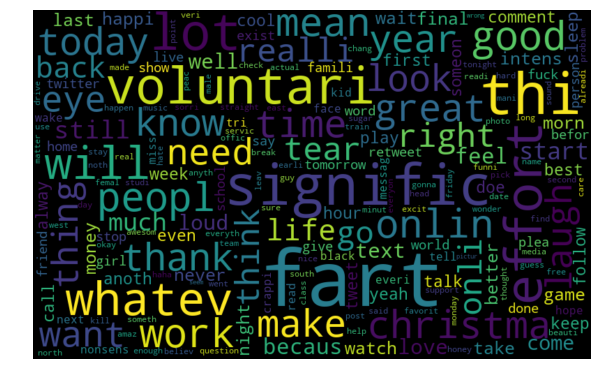

In [237]:
all_words = ' '.join([text for text in train['text']])
all_words = all_words.replace('user','')
all_words = all_words.replace('number','')
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, 
                      height=500, 
                      random_state=21, 
                      collocations=False,
                      max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [238]:
from operator import itemgetter

In [239]:
wordcounts = word_count(all_words)
sortedWords = sorted(wordcounts.items(), key=itemgetter(1), reverse = True)
sortedWords[:10]

[('fart', 732),
 ('that', 584),
 ('have', 506),
 ('other', 395),
 ('thi', 359),
 ('signific', 340),
 ('just', 324),
 ('with', 314),
 ('lot', 277),
 ('effort', 274)]

## Words Most Common in Non Ironic Tweets

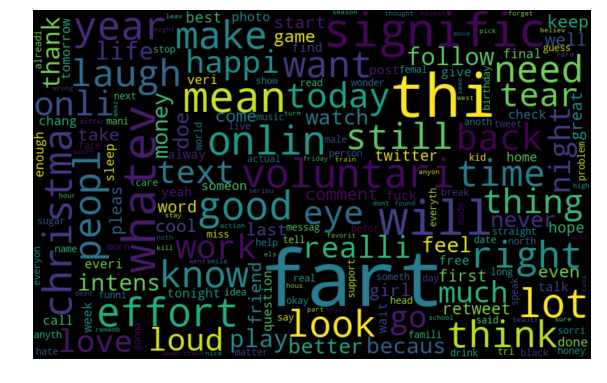

In [240]:
nonirony_words =' '.join([text for text in train['text'][train['label'] == 0]])
nonirony_words = nonirony_words.replace('user','')
nonirony_words = nonirony_words.replace('number','')
wordcloud = WordCloud(width=800, 
                      height=500, 
                      random_state=21,
                      collocations=False,
                      max_font_size=110).generate(nonirony_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [241]:
wordcounts = word_count(nonirony_words)
sortedWords = sorted(wordcounts.items(), key=itemgetter(1), reverse = True)
sortedWords[:10]

[('fart', 359),
 ('that', 264),
 ('have', 244),
 ('thi', 194),
 ('with', 173),
 ('just', 145),
 ('what', 141),
 ('other', 132),
 ('will', 120),
 ('your', 119)]

## Words Most Common in Ironic Tweets

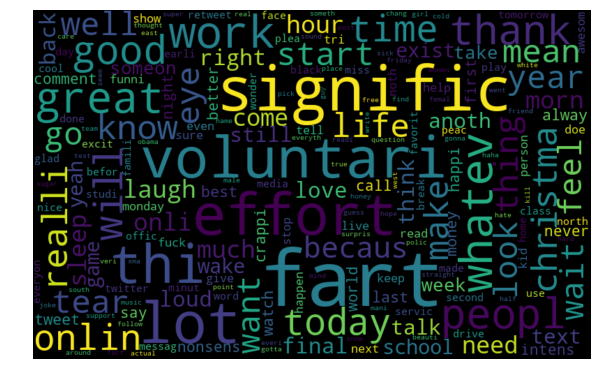

In [242]:
irony_words =' '.join([text for text in train['text'][train['label'] == 1]])
irony_words = irony_words.replace('user','')
irony_words = irony_words.replace('number','')
wordcloud = WordCloud(width=800, 
                      height=500, 
                      random_state=21,
                      collocations=False,
                      max_font_size=110).generate(irony_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [243]:
wordcounts = word_count(irony_words)
sortedWords = sorted(wordcounts.items(), key=itemgetter(1), reverse = True)
sortedWords[:10]

[('fart', 373),
 ('that', 320),
 ('other', 263),
 ('have', 262),
 ('signific', 226),
 ('lot', 193),
 ('effort', 191),
 ('voluntari', 188),
 ('just', 179),
 ('thi', 165)]

## Hashtags and Irony

In [264]:
''' 
function to collect hashtags

x: tweet string of text 

Return: list of hashtags from text
'''
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [269]:

# extracting hashtags from ironic tweets
HT_regular = hashtag_extract(train['orig'][train['label'] == 0])
HT_ironic = hashtag_extract(train['orig'][train['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular)
HT_ironic = sum(HT_ironic)

### Non-Ironic Hashtags

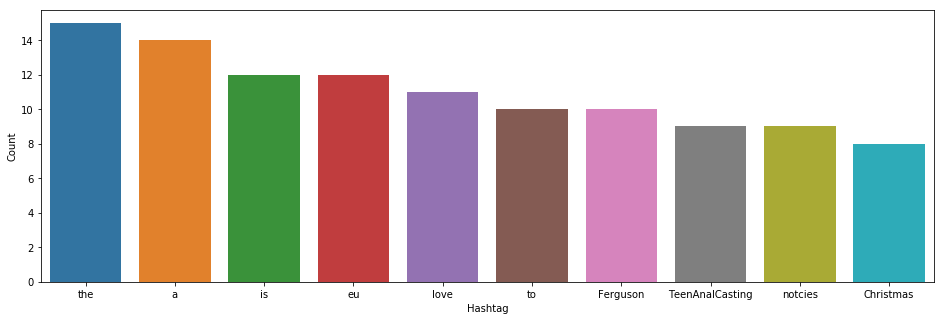

In [270]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

### Ironic Hashtages

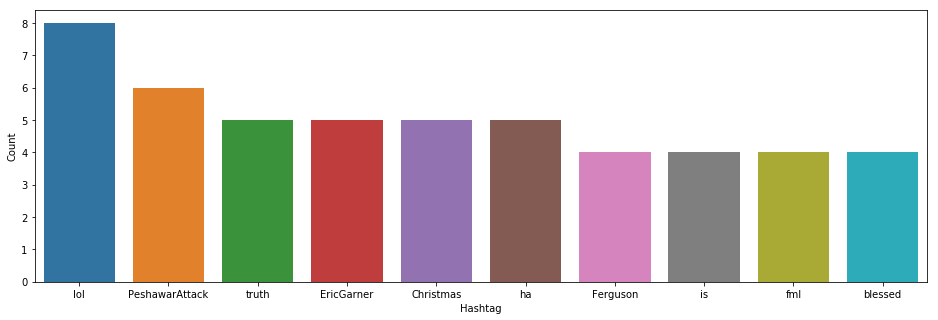

In [271]:
a = nltk.FreqDist(HT_ironic)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

## Visualizing Word Vectors

In [ ]:
def build_corpus(data):
    "Creates a list of lists containing words from each tweet"
    corpus = []
    for sentence in data['text'].iteritems():
        word_list = sentence[1].split(" ")
        corpus.append(word_list)       
    return corpus

In [ ]:
corpus = build_corpus(train)

In [ ]:
corpus = build_corpus(train)        
corpus[0:2]

In [ ]:
def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [ ]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=50, workers=4)

In [ ]:
tsne_plot(model)

## Topic Modelling

In [157]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
import numpy as np
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


/Users/christophersmyth/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [158]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [159]:
vect=CountVectorizer(ngram_range=(1,1),stop_words='english')

In [160]:
dtm=vect.fit_transform(train['text'])

In [161]:
dtm

<4373x6630 sparse matrix of type '<class 'numpy.int64'>'
	with 32008 stored elements in Compressed Sparse Row format>

In [162]:
pd.DataFrame(dtm.toarray(),columns=vect.get_feature_names())

,aaaaaaaaand,aaaaaaand,aaaaaamd,aaaaaand,aaaah,aaaaint,aaaawww,aaand,aand,aaron,...,zionist,zipper,zoella,zoloft,zombi,zone,zuckerberg,zuma,zzzz,zzzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [163]:
lda=LatentDirichletAllocation(n_components=5)

In [164]:
lda.fit_transform(dtm)

array([[0.02857578, 0.02882427, 0.02857575, 0.88544698, 0.02857722],
       [0.03356076, 0.03339149, 0.03365206, 0.86606127, 0.03333442],
       [0.02000068, 0.02000088, 0.02000072, 0.02000028, 0.91999744],
       ...,
       [0.2058226 , 0.02857221, 0.70826829, 0.02870337, 0.02863353],
       [0.09965923, 0.01436734, 0.14434157, 0.64618653, 0.09544533],
       [0.02885735, 0.46000896, 0.02862765, 0.45393357, 0.02857246]])

In [169]:
lda_dtf=lda.fit_transform(dtm)

In [165]:
import numpy as np
sorting=np.argsort(lda.components_)[:,::-1]
features=np.array(vect.get_feature_names())

In [189]:
import mglearn
mglearn.tools.print_topics(topics=range(5), feature_names=features,
sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
fart          fart          lot           user          fart          
great         tri           effort        number        better        
look          stop          voluntari     fart          christma      
make          hope          onlin         thi           best          
feel          happi         mean          signific      follow        
becaus        black         eye           just          school        
signific      messag        tear          whatev        music         
alway         guess         comment       like          noth          
just          peopl         today         good          excit         
someon        free          number        thank         happi         




In [190]:
from __future__ import  print_function
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [191]:
zit=pyLDAvis.sklearn.prepare(lda,dtm,vect)

/Users/christophersmyth/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [192]:
pyLDAvis.show(zit)


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [02/Oct/2018 16:53:40] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [02/Oct/2018 16:53:40] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [02/Oct/2018 16:53:40] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [02/Oct/2018 16:53:40] "GET /LDAvis.js HTTP/1.1" 200 -



stopping Server...


# Prepare for Feature Creation

In [ ]:
# split the dataset into training and validation datasets 
x_train, x_test, y_train, y_test = model_selection.train_test_split(train['text'], train['label'])

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

# Count Vector Features

In [ ]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
X = count_vect.fit(x_train)

In [ ]:
# transform the training and data using count vectorizer object
xtrain_count =  count_vect.transform(x_train)
xtest_count =  count_vect.transform(x_test)

# TF-IDF Vector Features

## word level tf-idf

In [ ]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(x_train)
xtrain_tfidf =  tfidf_vect.transform(x_train)
xtest_tfidf =  tfidf_vect.transform(x_test)

## ngram level tf-idf 

In [ ]:
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(x_train)
xtrain_tfidf_ngram = tfidf_vect_ngram.transform(x_train)
xtest_tfidf_ngram = tfidf_vect_ngram.transform(x_test)

## character level tf-idf

In [ ]:
# character level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(x_train)
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(x_train)
xtest_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(x_test)


# Word Embedding Features

In [ ]:
# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('data/wiki-news-300d-1M.vec')):
    values = line.split()
    embeddings_index[values[0]] = numpy.asarray(values[1:], dtype='float32')


In [ ]:
# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(x_train)
word_index = token.word_index

In [ ]:
# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(x_train), maxlen=70)
test_seq_x = sequence.pad_sequences(token.texts_to_sequences(x_test), maxlen=70)


In [ ]:
# create token-embedding mapping
embedding_matrix = numpy.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Models

In [ ]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, y_test)

## Naive Bayes

In [ ]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, y_train, xtest_count)
print ("NB, Count Vectors: " + str(accuracy))

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, y_train, xtest_tfidf)
print ("NB, WordLevel TF-IDF: "+ str(accuracy))

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram)
print ("NB, N-Gram Vectors: "+ str(accuracy))

# Naive Bayes on Character Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars)
print ("NB, CharLevel Vectors: "+str(accuracy))

## Linear Classifier

In [ ]:
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, y_train, xtest_count)
print ("LR, Count Vectors: " + str(accuracy))

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, y_train, xtest_tfidf)
print ("LR, WordLevel TF-IDF: "+str(accuracy))

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram)
print ("LR, N-Gram Vectors: "+str(accuracy))

# Linear Classifier on Character Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, y_train, xtest_tfidf_ngram_chars)
print ("LR, CharLevel Vectors: "+str(accuracy))

## SVM

In [ ]:
# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram)
print ("SVM, N-Gram Vectors: "+str(accuracy))

# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(svm.SVC(), xtrain_count, y_train, xtest_count)
print ("SVM, Count Vectors: "+str(accuracy))

## Extreme Gradient Boosting

In [ ]:
# Extereme Gradient Boosting on Count Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), y_train, xtest_count.tocsc())
print("Xgb, Count Vectors: "+str(accuracy))

# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), y_train, xtest_tfidf.tocsc())
print("Xgb, WordLevel TF-IDF: "+str(accuracy))

# Extereme Gradient Boosting on Character Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), y_train, xtest_tfidf_ngram_chars.tocsc())
print("Xgb, CharLevel Vectors: "+str(accuracy))

## Shollow Neural Network

In [ ]:
def create_model_architecture(input_size):
    # create input layer 
    input_layer = layers.Input((input_size, ), sparse=True)
    
    # create hidden layer
    hidden_layer = layers.Dense(100, activation="relu")(input_layer)
    
    # create output layer
    output_layer = layers.Dense(1, activation="sigmoid")(hidden_layer)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    return classifier 

classifier = create_model_architecture(xtrain_tfidf_ngram.shape[1])
accuracy = train_model(classifier, xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram, is_neural_net=True)
print ("NN, Ngram Level TF IDF Vectors "+str(accuracy))

## Deep Neural Networks

### Convolutional Neural Network

In [ ]:
def create_cnn():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_cnn()
accuracy = train_model(classifier, train_seq_x, y_train, test_seq_x, is_neural_net=True)
print ("CNN, Word Embeddings"+str(accuracy))

In [ ]:
def create_rnn_lstm():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.LSTM(100)(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rnn_lstm()
accuracy = train_model(classifier, train_seq_x, y_train, test_seq_x, is_neural_net=True)
print ("RNN-LSTM, Word Embeddings"+str(accuracy))